In [1]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.insert(0, '../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import sys
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# compute 1-sigma confidence intervals in 1D
def calc_cred_intervals_in_1d(P, x):

    # find the value of P corresponding to 50% and 9% confidence heights
    conf = confidence(P)
    P_s1 = conf.height_from_level(0.5)
    P_s2 = conf.height_from_level(0.9)

    # calculation of condifence edges (values of x corresponding to the height s1 on the two sides)
    x_s1_l = min(x[np.where(P >= P_s1)[0]])
    x_s1_r = max(x[np.where(P >= P_s1)[0]])

    # calculation of condifence edges (values of x corresponding to the height s2 on the two sides)
    x_s2_l = min(x[np.where(P >= P_s2)[0]])
    x_s2_r = max(x[np.where(P >= P_s2)[0]])

    return P_s1, P_s2, x_s1_l, x_s1_r, x_s2_l, x_s2_r

def plot_2d_histogram_details(x, y, N_bins):

    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    P_x = np.sum(P_xy, axis=0) * dy
    P_y = np.sum(P_xy, axis=1) * dx
    
    conf_xy = confidence(P_xy)
    s1_xy = conf_xy.height_from_level(0.5)
    s2_xy = conf_xy.height_from_level(0.9)
  
    s1_x, s2_x, left1_x, right1_x, left2_x, right2_x = calc_cred_intervals_in_1d(P_x, x_intp)
    s1_y, s2_y, left1_y, right1_y, left2_y, right2_y = calc_cred_intervals_in_1d(P_y, y_intp)

    return x_intp, y_intp, P_xy, P_x, P_y, s1_xy, s2_xy, s1_x, s2_x, left1_x, right1_x, left2_x, right2_x, s1_y, s2_y, left1_y, right1_y, left2_y, right2_y 

In [3]:
lm = [2,2]

gr_loc = '/home/abhirup.ghosh/Documents/Work/O3/2019/May/21/1242459857p4634/G333674/lalinference/20190525_pSEOBNRv4HM_GR_nonROQ/cbcBayes/posterior_samples.dat'
modgr_loc = '/home/abhirup.ghosh/Documents/Work/O3/2019/May/21/1242459857p4634/G333674/lalinference/20190525_pSEOBNRv4HM_domega220_dtauinv220_nonROQ/cbcBayes/posterior_samples.dat'


In [4]:
for postloc in [gr_loc, modgr_loc]:
    data = np.genfromtxt(postloc, names=True, dtype=None)
    if postloc == gr_loc:
        m1, m2, a1z, a2z = data['m1'], data['m2'], data['a1z'], data['a2z']
        omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
        freq_GR = omega_GR/(2.*np.pi)
        samples_freq_tau_GR = np.vstack((freq_GR, tau_GR*1000.)).T
        
    elif postloc == modgr_loc:
        m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtauinv220']
        omega_GR_tmp, tau_GR_tmp = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)        
        omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR_tmp, tau_GR_tmp , domega, dtau)
        freq_modGR = omega_modGR/(2.*np.pi)
        samples_freq_tau_modGR = np.vstack((freq_modGR, tau_modGR*1000.)).T

<IPython.core.display.Javascript object>


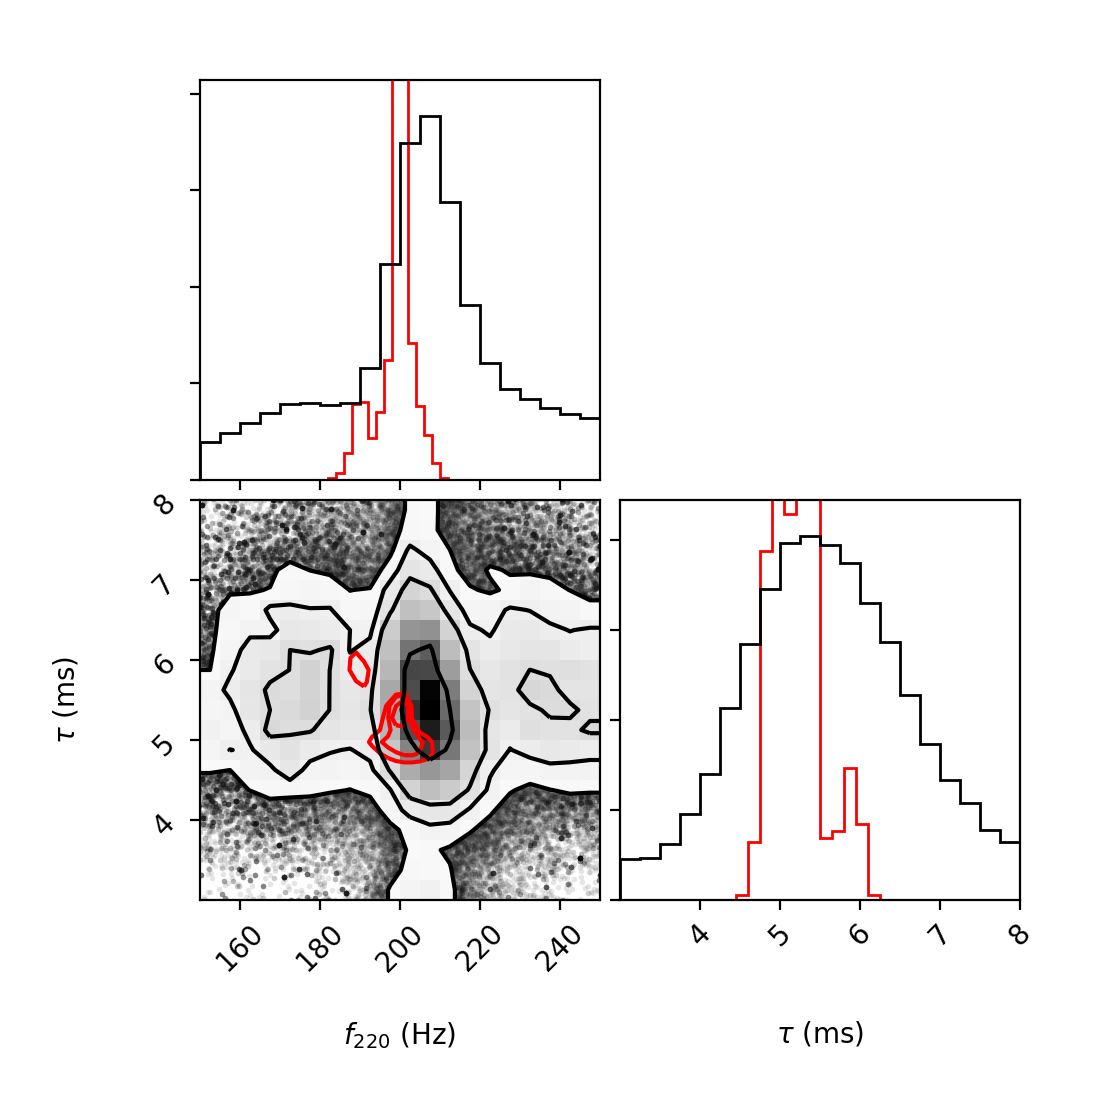

In [22]:
fig = corner.corner(samples_freq_tau_GR, range=[(180, 220), (4,7)], color='r')
corner.corner(samples_freq_tau_modGR, range=[(150, 250), (3,8)], labels=['$f_{220}$ (Hz)','$\\tau$ (ms)'], color='k', fig=fig)
plt.show()